In [24]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [25]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html

# Set the model to evaluation mode
model.eval()

print("Model Loaded")

Model Loaded


In [59]:
def display_bounding_boxes(input_image: torch.Tensor, model_outputs: dict, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()


def show_classifications(outputs: list, id_to_class: dict, THRESHOLD: float = 0.8) -> None:
    """
    Given the outputs of the model, print the class and score of each object detected

    Args:
        outputs (list): The outputs of the model
        id_to_class (dict): A dictionary mapping class IDs to class names
        THRESHOLD (float): The minimum score for an object to be considered detected
    """
    for i in range(len(outputs[0]['scores'])):
        if outputs[0]['scores'][i] >= THRESHOLD:
            print(f"{id_to_class[int(outputs[0]['labels'][i])]}, Score: {outputs[0]['scores'][i]:2f}")
    

In [27]:
# Pass test_image.jpg thrpugh the model
image_path = '../data/test_image_2.jpg'
image = Image.open(image_path)
print(type(image))

# Dont need to normalize the input iamges, the pytorch model does it internally
tensor_transform = transforms.ToTensor()

# Apply the transformation to your image
normalized_image = tensor_transform(image).unsqueeze(0)

outputs = model(normalized_image)
print(outputs)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[{'boxes': tensor([[535.3391,  20.0719, 609.7738, 178.4507],
        [542.2030, 154.5199, 604.9759, 235.9574],
        [456.3945, 428.5459, 564.2382, 576.1763],
        [546.1974,  44.2276, 595.2899, 130.2017],
        [574.7860,   2.9583, 625.1684, 142.2021],
        [322.0666, 244.4988, 424.8631, 412.8845],
        [347.1685,   0.0000, 401.0104,  76.4559],
        [  3.6247,  12.7486, 555.5764, 652.7388],
        [427.9813, 568.3328, 518.2085, 637.2108],
        [386.8102,  25.0270, 429.6099,  73.1377],
        [ 37.2523, 179.8750, 199.4702, 426.9713],
        [ 29.3347, 242.0493, 143.6500, 427.2611],
        [  0.0000, 414.4947, 425.7800, 670.6819],
        [ 80.9737, 181.1380, 516.7618, 651.2839],
        [430.1860, 570.1470, 516.8325, 633.6723],
        [290.1415, 258.9033, 507.2377, 663.0112],
        [ 84.3840, 205.1122, 161.6413, 304.1184],
        [283.1932,  10.4326, 364.0245, 105.3970],
        [265.7511,   1.3581, 322.7600,  48.07

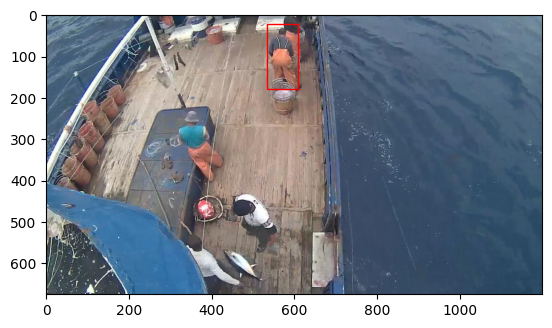

In [28]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.98)

In [60]:
def calc_iou(box1: list, box2: list):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
        box1: list of floats (x_min, y_min, x_max, y_max)
        box2: list of floats (x_min, y_min, x_max, y_max)

    Returns:
        float: intersection over union (IoU) between box1 and box2
    """
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # compute the IoU
    iou = intersection_area / union_area

    return iou
    

class_to_id = {'Human': 0, 'Swordfish': 1, 'Albacore': 2, 'Yellowfin tuna': 3, 'No fish': 4, 'Mahi mahi': 5, 'Skipjack tuna': 6, 'Unknown': 7, 'Wahoo': 8, 'Bigeye tuna': 9, 'Striped marlin': 10, 'Opah': 11, 'Blue marlin': 12, 'Escolar': 13, 'Shark': 14, 'Tuna': 15, 'Water': 16, 'Oilfish': 17, 'Pelagic stingray': 18, 'Marlin': 19, 'Great barracuda': 20, 'Shortbill spearfish': 21, 'Indo Pacific sailfish': 22, 'Lancetfish': 23, 'Long snouted lancetfish': 24, 'Black marlin': 25}
id_to_class = {v: k for k, v in class_to_id.items()}



In [43]:
# # Show all model layers
# for name, param in model.named_parameters():
#     print(name, param.size())

In [35]:
finetuned_model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
in_features = finetuned_model.roi_heads.box_predictor.cls_score.in_features
num_classes = 26
finetuned_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

weights_path = '../data/best_model.pth'
trained_weights = torch.load(weights_path, map_location=torch.device('cpu'))

finetuned_model.load_state_dict(trained_weights)

finetuned_model.eval()

print("Model Loaded")

Model Loaded


In [54]:
outputs = finetuned_model(normalized_image)
outputs_og = model(normalized_image)

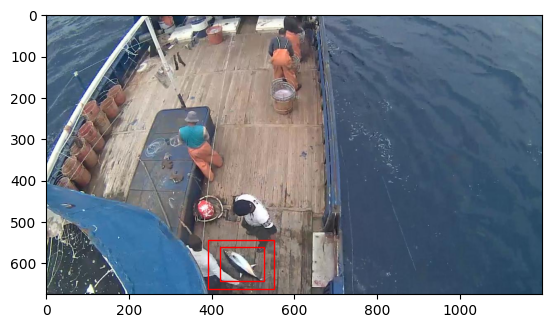

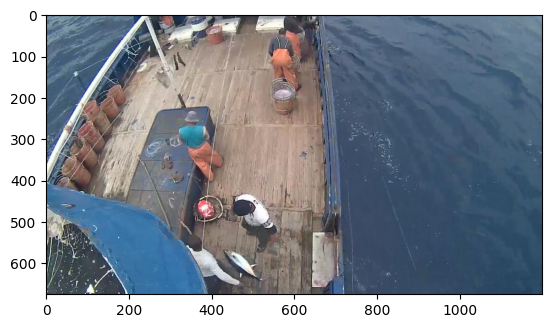

Albacore, Score: 0.920983
Albacore, Score: 0.660766


In [58]:
THRESHOLD = 0.5

display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=THRESHOLD)
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs_og, thresh=THRESHOLD)

show_classifications(outputs, THRESHOLD)
show_classifications(outputs_og, THRESHOLD)

In [59]:
model.train()
print("Model in training mode")

Model in training mode
